In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import json
import joblib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pytorch_lightning as pl
from torchvision import transforms, models
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
from tqdm import tqdm

### t-distributed stochastic neighbor embedding (t-SNE)

Processing Supervised...


Extracting features (Supervised): 100%|███████████████████████████████████████████| 2002/2002 [00:16<00:00, 122.38it/s]


Processing SimCLR...


Extracting features (SimCLR): 100%|███████████████████████████████████████████████| 2002/2002 [00:16<00:00, 122.37it/s]


Processing BYOL...


Extracting features (BYOL): 100%|█████████████████████████████████████████████████| 2002/2002 [00:16<00:00, 123.75it/s]


Saved high-resolution figure at: tsne_convnext_supervised_simclr_byol_final_colored_by_crop.png


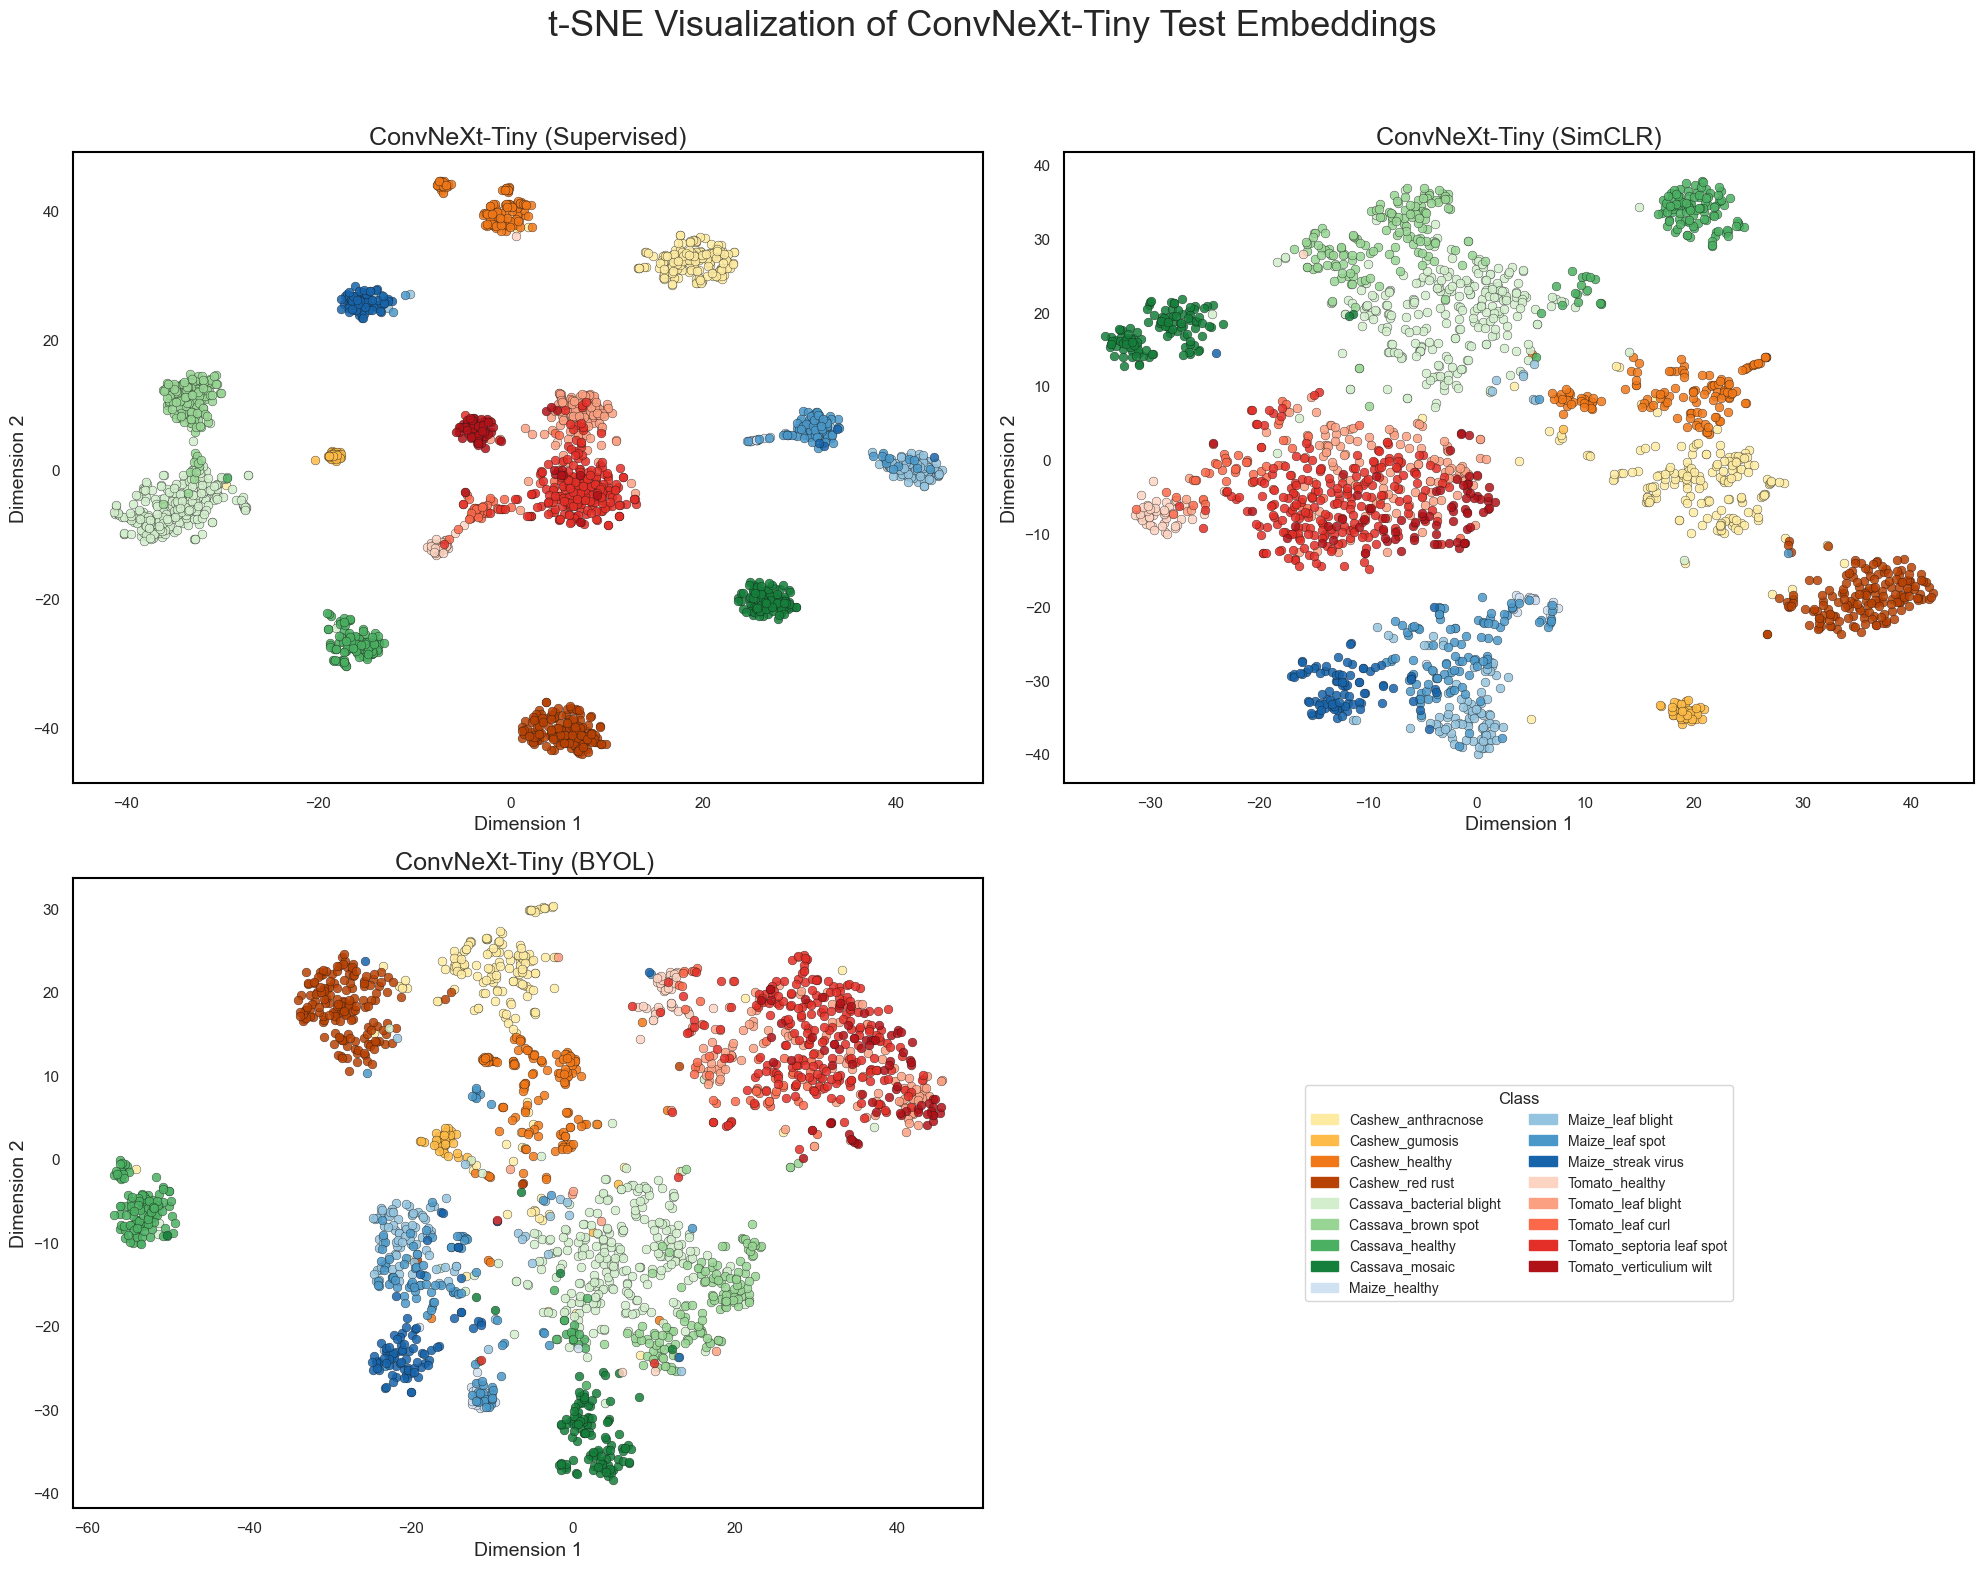

In [2]:
# define paths to model checkpoints, dataset, and index files
base_dirs = {
    "supervised": r"c:/users/xuxu/desktop/master thesis/supervisedbaselinever2epoch100/single_run/version_0",
    "simclr": r"c:/users/xuxu/desktop/master thesis/simclrbaselineepoch100/single_run/version_0",
    "byol": r"c:/users/xuxu/desktop/master thesis/byolbaselinever2epoch50/single_run/version_0"
}
index_dir = r"c:/users/xuxu/desktop/master thesis/optunadensenetfull"
dataset_root = r"c:/users/xuxu/desktop/ccmt dataset"
optuna_pkl = r"c:/users/xuxu/desktop/master thesis/optunaconvnextfull/new_convnext_study.pkl"

# define custom dataset class for loading images
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("rgb")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# define convnext-tiny lightning module for inference
class ConvNextTinyLightning(pl.LightningModule):
    def __init__(self, num_classes, class_weights, hparams):
        super().__init__()
        self.hparams_dict = hparams
        self.class_weights = class_weights
        self.num_classes = num_classes

        self.model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        for param in self.model.features.parameters():
            param.requires_grad = True

        in_features = self.model.classifier[2].in_features
        fc_hidden_dim = hparams["fc_hidden_dim"]
        dropout = hparams["dropout"]
        fc_layers = hparams.get("fc_layers", 1)

        layers = [nn.Flatten(start_dim=1)]
        if fc_layers == 1:
            layers.append(nn.Linear(in_features, num_classes))
        else:
            layers.extend([
                nn.Linear(in_features, fc_hidden_dim),
                nn.BatchNorm1d(fc_hidden_dim),
                nn.ReLU(),
                nn.Dropout(p=dropout)
            ])
            for _ in range(fc_layers - 2):
                layers.extend([
                    nn.Linear(fc_hidden_dim, fc_hidden_dim),
                    nn.BatchNorm1d(fc_hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(p=dropout)
                ])
            layers.append(nn.Linear(fc_hidden_dim, num_classes))

        self.model.classifier = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# load class-to-index mapping and reverse it
with open(os.path.join(index_dir, "class_to_idx.json")) as f:
    class_to_idx = json.load(f)
idx_to_class = {v: k for k, v in class_to_idx.items()}

# load test indices and class weights
test_indices = np.load(os.path.join(index_dir, "test_indices.npy"))
class_weights = torch.load(os.path.join(index_dir, "class_weights.pt"))

# gather all image paths and their corresponding labels
image_paths, labels = [], []
for crop in sorted(os.listdir(dataset_root)):
    for disease in sorted(os.listdir(os.path.join(dataset_root, crop))):
        class_name = f"{crop}_{disease}"
        class_idx = class_to_idx[class_name]
        img_dir = os.path.join(dataset_root, crop, disease)
        for img_file in os.listdir(img_dir):
            if img_file.lower().endswith(("jpg", "jpeg", "png")):
                image_paths.append(os.path.join(img_dir, img_file))
                labels.append(class_idx)

labels = np.array(labels)

# define transformation for evaluation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# create test dataset using test indices
test_set = CustomImageDataset(
    [image_paths[i] for i in test_indices],
    [labels[i] for i in test_indices],
    transform=transform
)

# load best hyperparameters from optuna study
study = joblib.load(optuna_pkl)
best_hparams = study.best_trial.params
best_hparams["lr"] = best_hparams.pop("learning_rate")

# initialize containers for tsne features and targets
tsne_results_all = {}
targets_all = None

# extract features from each model
for model_name, base_dir in base_dirs.items():
    print(f"processing {model_name}...")
    model_path = os.path.join(base_dir, "model.pth")

    model = ConvNextTinyLightning(
        num_classes=len(class_to_idx),
        class_weights=class_weights,
        hparams=best_hparams
    )
    model.load_state_dict(torch.load(model_path), strict=False)
    model.eval().cuda()

    features, targets = [], []

    with torch.no_grad():
        for img_tensor, label in tqdm(test_set, desc=f"extracting features ({model_name})"):
            input_tensor = img_tensor.unsqueeze(0).cuda()
            x = model.model.features(input_tensor)
            x = model.model.avgpool(x)
            x = torch.flatten(x, 1)
            features.append(x.squeeze().cpu().numpy())
            targets.append(label)

    features = np.stack(features)
    if targets_all is None:
        targets_all = np.array(targets)

    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_result = tsne.fit_transform(features)
    tsne_results_all[model_name] = tsne_result

# set up plotting environment
sns.set(style="white")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

# define plot titles for each model
model_titles = {
    "supervised": "convnext-tiny (supervised)",
    "simclr": "convnext-tiny (simclr)",
    "byol": "convnext-tiny (byol)",
}

# define crops and their associated classes
crop_to_classes = {
    "cashew": ["Cashew_anthracnose", "Cashew_gumosis", "Cashew_healthy", "Cashew_red rust"],
    "cassava": ["Cassava_bacterial blight", "Cassava_brown spot", "Cassava_healthy", "Cassava_mosaic"],
    "maize": ["Maize_healthy", "Maize_leaf blight", "Maize_leaf spot", "Maize_streak virus"],
    "tomato": ["Tomato_healthy", "Tomato_leaf blight", "Tomato_leaf curl", "Tomato_septoria leaf spot", "Tomato_verticulium wilt"]
}

# assign distinct color maps to each crop
crop_colormaps = {
    "cashew": get_cmap("YlOrBr"),
    "cassava": get_cmap("Greens"),
    "maize": get_cmap("Blues"),
    "tomato": get_cmap("Reds")
}

# assign specific colors to each class based on its crop
class_to_color = {}
class_to_crop = {}
for crop, classes in crop_to_classes.items():
    cmap = crop_colormaps[crop]
    n = len(classes)
    for i, class_name in enumerate(classes):
        color = cmap((i + 1) / (n + 1))
        class_to_color[class_name] = color
        class_to_crop[class_name] = crop

# maintain legend label ordering
legend_labels = []
for crop in crop_to_classes.keys():
    legend_labels.extend(crop_to_classes[crop])

# create one scatter plot per model
for idx, (model_name, tsne_result) in enumerate(tsne_results_all.items()):
    ax = axes[idx]
    for class_idx, class_name in idx_to_class.items():
        indices = np.where(targets_all == class_idx)
        color = class_to_color[class_name]
        ax.scatter(
            tsne_result[indices, 0],
            tsne_result[indices, 1],
            s=40,
            color=color,
            label=class_name,
            alpha=0.85,
            edgecolors="k",
            linewidths=0.3
        )
    ax.set_title(model_titles[model_name], fontsize=18)
    ax.set_xlabel("dimension 1", fontsize=14)
    ax.set_ylabel("dimension 2", fontsize=14)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color("black")
        spine.set_linewidth(1.5)

# use the last subplot for displaying the legend
axes[-1].axis("off")
handles = [mpatches.Patch(color=class_to_color[class_name], label=class_name) for class_name in legend_labels]
axes[-1].legend(
    handles=handles,
    title="class",
    loc="center",
    bbox_to_anchor=(0.5, 0.5),
    ncol=2,
    fontsize="small",
    title_fontsize="medium",
)

# add title and save the figure
plt.suptitle("tsne visualization of convnext-tiny test embeddings", fontsize=26)
plt.tight_layout(rect=[0, 0, 1, 0.95])
save_path = "tsne_convnext_supervised_simclr_byol_final_colored_by_crop.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"saved high-resolution figure at: {save_path}")

# show the final plot
plt.show()

plt.show()


### Label Efficiency Test

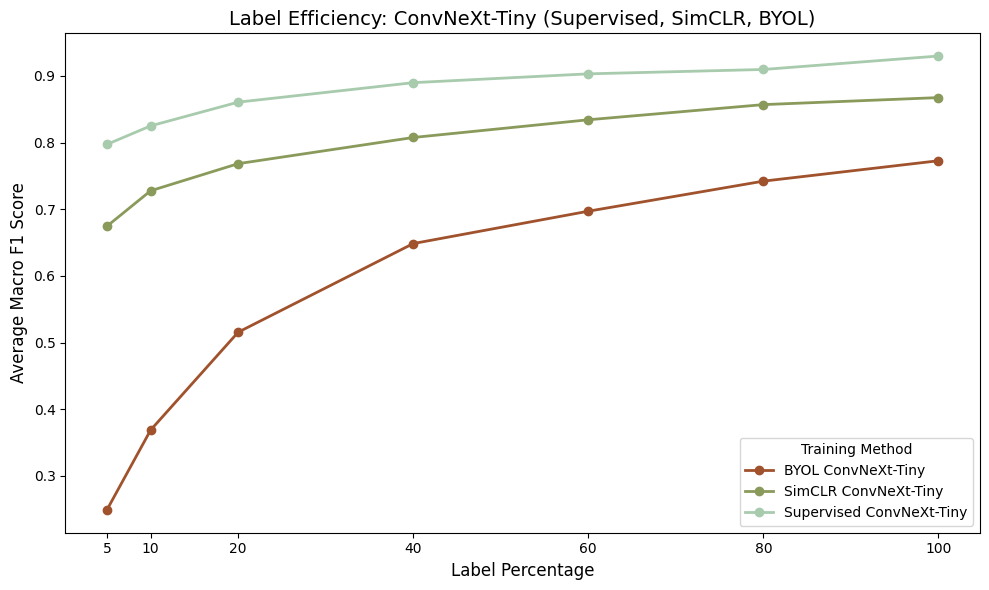

In [68]:

# directory mappings for each method
root_dirs = {
    "BYOL ConvNeXt-Tiny": ["BYOLBaselineLabelEfficiencySeed43", "BYOLBaselineLabelEfficiencySeed44", "BYOLBaselineLabelEfficiency"],
    "SimCLR ConvNeXt-Tiny": ["SIMCLRBaselineLabelEfficiencySeed43", "SIMCLRBaselineLabelEfficiencySeed44", "SIMCLRBaselineLabelEfficiency"],
    "Supervised ConvNeXt-Tiny": ["SupervisedBaselineLabelEfficiencySeed43", "SupervisedBaselineLabelEfficiencySeed44", "SupervisedBaselineLabelEfficiency"]
}

label_percents = [5, 10, 20, 40, 60, 80, 100]
averaged_results = {}

# aggregate and average macro f1 scores
for method, dirs in root_dirs.items():
    method_scores = {percent: [] for percent in label_percents}

    for d in dirs:
        for percent in label_percents:
            version_dir = os.path.join(dataset_root, d, f"label_efficiency_{percent}percent", "version_0")
            preds_path = os.path.join(version_dir, "all_preds.npy")
            targets_path = os.path.join(version_dir, "all_targets.npy")

            if os.path.exists(preds_path) and os.path.exists(targets_path):
                preds = np.load(preds_path)
                targets = np.load(targets_path)
                f1 = f1_score(targets, preds, average="macro")
                method_scores[percent].append(f1)

    averaged_results[method] = [
        np.mean(method_scores[p]) if method_scores[p] else None for p in label_percents
    ]

# updated earthy color palette
colors = {
    "Supervised ConvNeXt-Tiny": "#A8CBAE",   # Maize - light sage green
    "SimCLR ConvNeXt-Tiny": "#8A9A5B",       # Cassava - muted olive
    "BYOL ConvNeXt-Tiny": "#A0522D"          # Tomato - earthy reddish brown
}

# plotting averaged results
plt.figure(figsize=(10, 6))
for method, scores in averaged_results.items():
    plt.plot(label_percents, scores, marker="o", label=method, color=colors[method], linewidth=2)

plt.xlabel("label percentage", fontsize=12)
plt.ylabel("average macro f1 score", fontsize=12)
plt.title("label efficiency: convnext-tiny (supervised, simclr, byol)", fontsize=14)
plt.legend(title="training method", fontsize=10)
plt.xticks(label_percents)
plt.tight_layout()

# save high-resolution figure
save_path = os.path.join(dataset_root, "label_efficiency_convnext_tiny_comparison.png")
plt.savefig(save_path, dpi=300)
plt.show()
